## Construction premier VAE pour spectrogramme 
...on marque bien les changements avec le notebook 1erTest

In [1]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader 
import os 
import numpy as np

In [2]:
folder_path = "../Data/charly/spectrograms_win800_fra200_rFalse_nfft800_nmelsNone_amptodbTrue/"
all_wav = []
folders_locuteur = os.listdir(folder_path)
for folder in folders_locuteur:
    wav_files = os.listdir(folder_path + folder)
    for wav in wav_files:
        all_wav.append(folder_path + folder + "/" + wav)
np.random.shuffle(all_wav)
print(type(all_wav))

#### attention on ne transpose plus les spectrogrammes (comme pour VAEcharly)
#### et on les unsqueeze pour passer de 3 à 4 dimensions

<class 'list'>


In [11]:
class SpectroDataset(Dataset):
    """
    A custom dataset to load spectrograms
    """
    def __init__(self, datapath):
        self.path = datapath

# dans le cas où ne peut pas charger toutes les données en RAM en même temps, 
# on charge les données et on les transforme uniquement lors de l'appel de la méthode __getitem__
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        link = self.path[idx]
        spectro = np.load(link)
        #spectro = np.transpose(spectro)
        spectro = np.expand_dims(spectro, axis=0)
        spectro = torch.from_numpy(spectro)
        return spectro
        

In [12]:
spectro_path = all_wav[:1000]
spectros = SpectroDataset(spectro_path) 
data_loader = DataLoader(spectros,batch_size=16,shuffle=True)

In [13]:
batch = next(iter(data_loader))
print(batch.shape)

torch.Size([16, 401, 21])


In [ ]:
#visualisation batch
import matplotlib.pyplot as plt
plt.imshow(batch[0][0])

## Entrainement d'un VanillaVAE

In [19]:
import importlib as implib

import models.modules.bottleneck as Bottleneck
import models.modules.CNNdecoder as Decoder
import models.modules.CNNencoder as Encoder
import models.vanillaVAE as VAE
import models.VAEcharly as VAEcharly

implib.reload(Bottleneck)
implib.reload(Decoder)
implib.reload(Encoder)
implib.reload(VAE)
implib.reload(VAEcharly)

<module 'models.VAEcharly' from '/home/hippo/Documents/voiceVAE/models/VAEcharly.py'>

In [20]:
z_dim = 64
encoder = Encoder.ConvolutionalEncoder(z_dim= z_dim)
bottleneck = Bottleneck.VariationalBottleneck(z_dim= z_dim)
decoder = Decoder.ConvolutionalDecoder(z_dim= z_dim)
vVAE = VAE.vanillaVAE(encoder, bottleneck, decoder, beta= 0)
charlyVAE = VAEcharly.VAECharly(encoder, bottleneck, decoder, beta= 0, metric_name= 'mse', init= None)

In [ ]:
#on affiche le nombre de paramètres du modèle
print(sum(p.numel() for p in vVAE.parameters() if p.requires_grad))
print(sum(p.numel() for p in charlyVAE.parameters() if p.requires_grad))
params = vVAE.parameters()
lparams = list(params)
print(lparams[0].shape)
print(lparams[1].shape)
print(lparams[2].shape)
print(lparams[3].shape)

In [ ]:
#Training loop
num_epochs = 5
device = 'cpu'
outputs = []
optimizer = torch.optim.Adam(charlyVAE.parameters(), lr=1e-3, weight_decay=1e-5)


for epoch in range(num_epochs):
    i=0
    print(f'Epoch {epoch+1}/{num_epochs}')
    for batch in data_loader:      
        results = charlyVAE(batch)
        recon = results['logits']
        loss, details = charlyVAE.minibatch_loss(batch=batch, device= device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        i+=1
        if i % 10 == 0:
            print('batch', i , 'over' ,len(data_loader))
        

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, batch, recon))

    # model.eval()
    # val_losses = list()
    # with torch.no_grad():
    #     for batch in tqdm(stream.val_loader, desc=str(epoch), leave=False):
    #         loss, _ = model.minibatch_loss(batch, device, scaler)
    #         val_losses.append(loss)
    # val_loss = torch.mean(torch.stack(val_losses))
    # print(f'[epoch={epoch+1}] val loss: {val_loss.item()}')

## Visualisation resultats

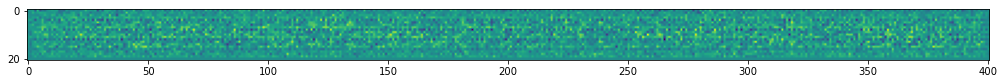

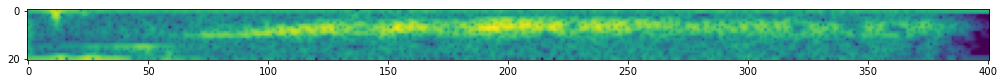

NEXT_SPECTRO


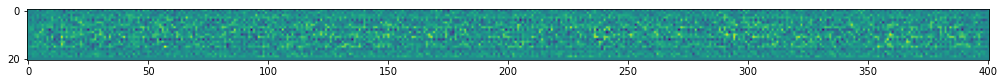

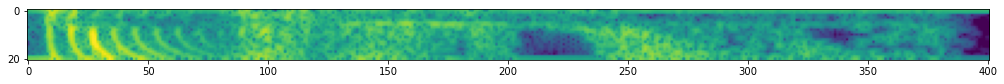

NEXT_SPECTRO


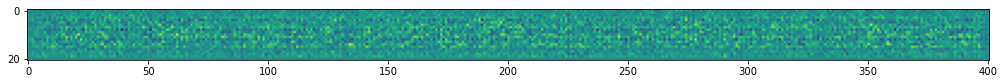

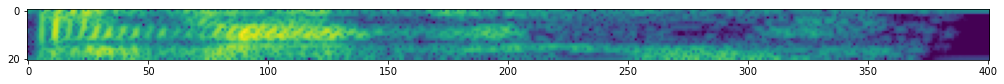

NEXT_SPECTRO


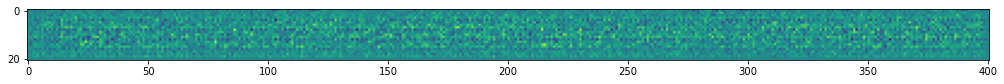

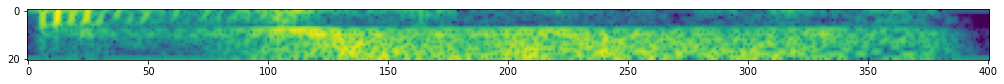

NEXT_SPECTRO


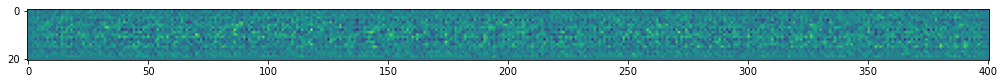

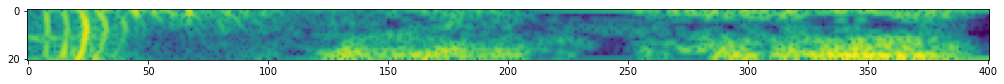

NEXT_SPECTRO


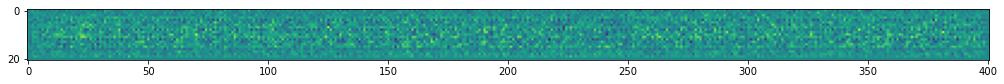

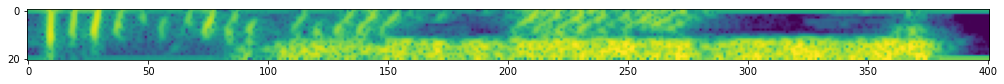

NEXT_SPECTRO


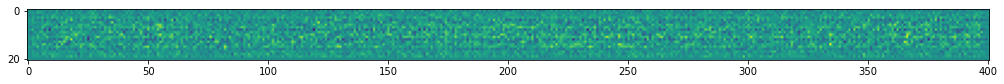

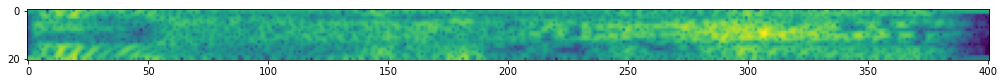

NEXT_SPECTRO


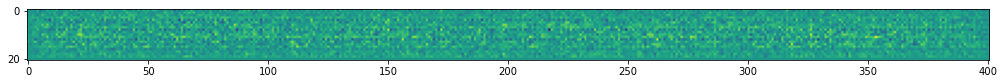

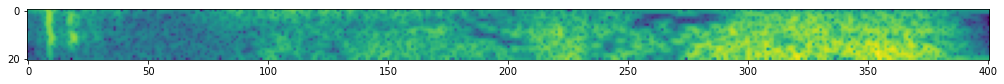

NEXT_SPECTRO


In [45]:

batch = next(iter(data_loader))
results = charlyVAE(batch)
recon = results['logits']

trecon = recon.transpose(2,3)
tbatch = batch.transpose(2,3)

#affichage des reocnstruction et des spectros originaux 
plt.rcParams['figure.figsize'] = [100, 50]
for i in range(8):
    plt.subplot(2,5,i+1)
    plt.imshow(trecon[i][0].detach().numpy())
    plt.show()
    plt.subplot(2,5,i+1)
    plt.imshow(tbatch[i][0].detach().numpy())
    plt.show()
    print('NEXT_SPECTRO')

In [ ]:
#training convenable 
#Gridsearch à mettre en place 